# MCMC — Notes for a talk

## What this notebook covers and key results

This notebook contains a practical, hands-on set of demos and examples for MCMC including, a high-dimensional Bayesian linear regression example where a simple VI projection performs very well (and is fast), while MCMC recovers the multimodality, and several MCMC algorithm demos (random-walk MH, Gibbs sampling, slice sampling, HMC / NUTS, RJMCMC and convergence diagnostics).

Below are short, section-by-section notes and the main observed results you can show during a talk (no code or computations were changed).

In [47]:
import warnings
warnings.filterwarnings("ignore")


## GIF generation

Generating GIF...
GIF saved as 'mcmc_chain_animation.gif'


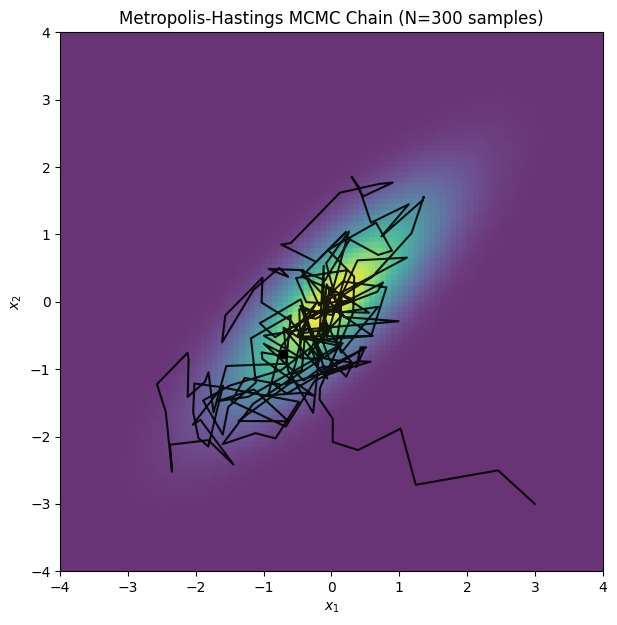

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 1. Target 2D Gaussian Definition
# -----------------------------
np.random.seed(123)

mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, 0.8],
                  [0.8, 1.0]])

Sigma_inv = np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)
norm_const = 1.0 / (2.0 * np.pi * np.sqrt(Sigma_det))

def log_target(x):
    dx = x - mu
    return -0.5 * np.dot(dx.T, np.dot(Sigma_inv, dx)) + np.log(norm_const)

# -----------------------------
# 2. Random Walk Metropolis-Hastings
# -----------------------------
n_samples = 300
step_size = 0.5

samples = np.zeros((n_samples, 2))
x_curr = np.array([3.0, -3.0])
samples[0] = x_curr
logp_curr = log_target(x_curr)

for t in range(1, n_samples):
    proposal = x_curr + np.random.normal(loc=0, scale=step_size, size=2)
    logp_prop = log_target(proposal)
    log_alpha = logp_prop - logp_curr

    if np.log(np.random.rand()) < log_alpha:
        x_curr = proposal
        logp_curr = logp_prop

    samples[t] = x_curr

# -----------------------------
# 3. Background Heatmap
# -----------------------------
xmin, xmax = -4, 4
ymin, ymax = -4, 4
grid_points = 100

x = np.linspace(xmin, xmax, grid_points)
y = np.linspace(ymin, ymax, grid_points)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

dx = pos - mu
exp_term = -0.5 * np.einsum('...i,ij,...j->...', dx, Sigma_inv, dx)
pdf = norm_const * np.exp(exp_term)

# -----------------------------
# 4. Animation Setup
# -----------------------------
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(
    pdf,
    extent=[xmin, xmax, ymin, ymax],
    origin="lower",
    aspect="auto",
    cmap="viridis",
    alpha=0.8,
)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title(f"Metropolis-Hastings MCMC Chain (N={n_samples} samples)")

line, = ax.plot([], [], lw=1.5, alpha=0.9, color="black", label="MCMC Path")
point, = ax.plot([], [], 'o', ms=6, color="black", label="Current State", zorder=5)
text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
               bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Variable-speed indices (sample indices)
indices = list(range(1, 15))            # Very slow
indices.extend(range(15, 50, 3))        # Medium
indices.extend(range(50, 100, 10))      # Fast
indices.extend(range(100, n_samples, 25))  # Very fast

if (n_samples - 1) not in indices:
    indices.append(n_samples - 1)

n_frames = len(indices)

def init():
    line.set_data([], [])
    point.set_data([], [])
    text.set_text('')
    return line, point, text

def update(frame_i):
    # frame_i = 0,1,...,n_frames-1
    t = indices[frame_i]      # sample index
    pts = samples[:t + 1]

    line.set_data(pts[:, 0], pts[:, 1])
    # ⬇⬇⬇ AQUÍ EL CAMBIO IMPORTANTE: listas / arrays, no escalares
    point.set_data([pts[-1, 0]], [pts[-1, 1]])

    return line, point, text

anim = FuncAnimation(
    fig,
    update,
    frames=n_frames,
    init_func=init,
    interval=100,
    blit=False,
    repeat=False
)

print("Generating GIF...")

anim.save('mcmc_chain_animation.gif', writer='pillow', fps=3)

print("GIF saved as 'mcmc_chain_animation.gif'")
plt.show()


## Basic Idea of MCMC

### Results (Example 2 — multimodal posterior)

What the code demonstrates
- A simple, instructive 1D example where the target posterior is a bimodal mixture of Gaussians and a single-Gaussian variational approximation is inherently limited.
- The notebook runs a grid-search to find the best single Gaussian q (minimizing KL(q||p) approximately) and a Random-Walk Metropolis MCMC to sample from the true mixture.

Observed results (from running the code in this environment)
- The best single-Gaussian q collapses onto one of the modes (example: mu ≈ 3.00, sigma ≈ 0.53 in the demo run), so it misses the other mode entirely.
- KL-est (best single Gaussian) ≈ 0.69; MCMC (20k iters) samples show both modes present and the histogram of samples covers both peaks.
- Timing: MCMC sampling (20k iterations) was measured at ~0.09 s in the environment run. The grid-search/VI steps are quick for a 1D experiment.

Takeaway for a talk
- Use this slide to make the point that simple VI families (single Gaussians) tend to place all mass on the most convenient mode (minimizing KL(q||p)), while MCMC can represent multimodality if the sampler mixes well.

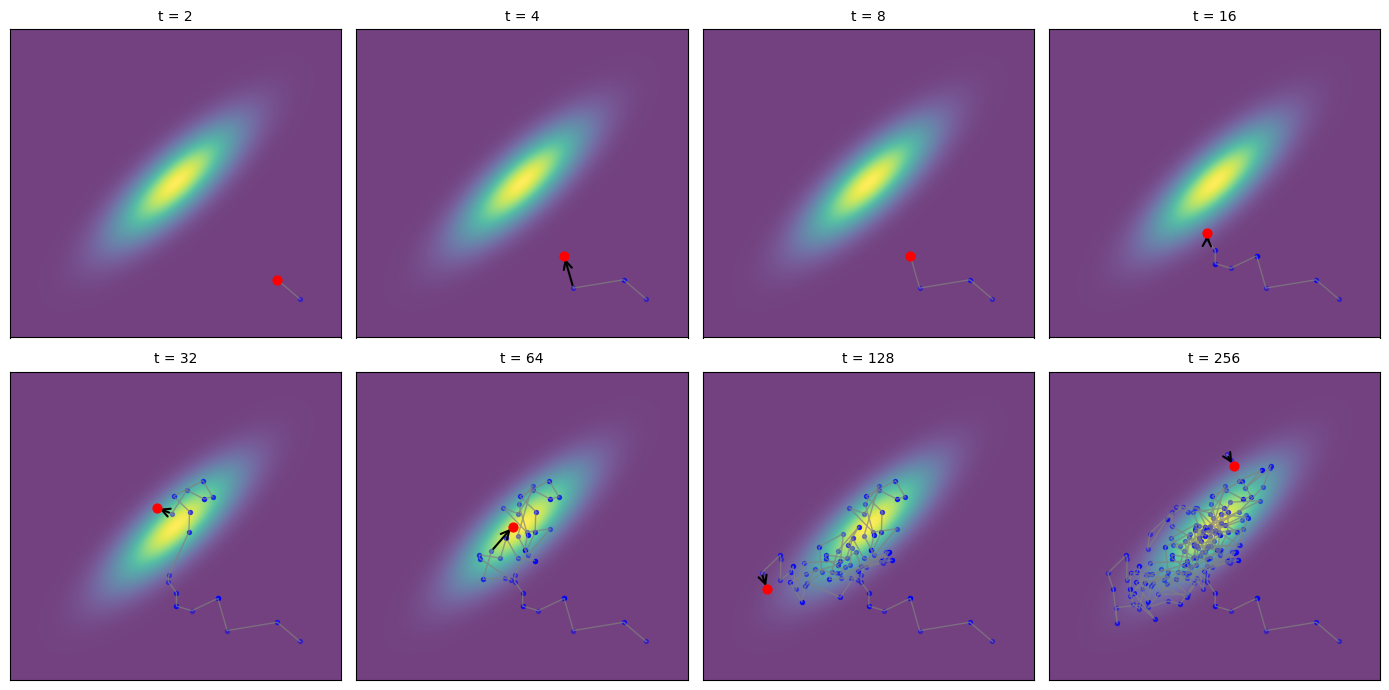

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Target 2D Gaussian
# -----------------------------
np.random.seed(123)

mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, 0.8],
                  [0.8, 1.0]])

Sigma_inv = np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)
norm_const = 1.0 / (2.0 * np.pi * np.sqrt(Sigma_det))

def log_target(x):
    """Log of 2D Gaussian density."""
    dx = x - mu
    return -0.5 * np.dot(dx.T, np.dot(Sigma_inv, dx)) + np.log(norm_const)

# -----------------------------
# 2. Run a simple MCMC (RW-MH)
# -----------------------------
n_samples = 300
step_size = 0.5

samples = np.zeros((n_samples, 2))
x_curr = np.array([3.0, -3.0])
samples[0] = x_curr
logp_curr = log_target(x_curr)

for t in range(1, n_samples):
    proposal = x_curr + np.random.normal(scale=step_size, size=2)
    logp_prop = log_target(proposal)

    log_alpha = logp_prop - logp_curr
    if np.log(np.random.rand()) < log_alpha:
        x_curr = proposal
        logp_curr = logp_prop

    samples[t] = x_curr

# -----------------------------
# 3. Background Heatmap of Target PDF
# -----------------------------
xmin, xmax = -4, 4
ymin, ymax = -4, 4

grid_points = 400
x = np.linspace(xmin, xmax, grid_points)
y = np.linspace(ymin, ymax, grid_points)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

dx = pos - mu
exp_term = -0.5 * np.einsum('...i,ij,...j->...', dx, Sigma_inv, dx)
pdf = norm_const * np.exp(exp_term)

# -----------------------------
# 4. Plot 8 snapshots in a 2x4 figure (no saving, no legend)
# -----------------------------
indices_to_plot = [2**i for i in range(1, 9)]  # 2, 4, ..., 256

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.ravel()

for ax, idx in zip(axes, indices_to_plot):
    if idx >= n_samples:
        ax.axis("off")
        continue

    pts = samples[:idx + 1]

    # Background heatmap
    ax.imshow(
        pdf,
        extent=[xmin, xmax, ymin, ymax],
        origin="lower",
        aspect="auto",
        cmap="viridis",
        alpha=0.75,
    )

    # Path of the chain
    ax.plot(pts[:, 0], pts[:, 1], color="gray", lw=1, alpha=0.7)

    # Point cloud
    ax.scatter(pts[:, 0], pts[:, 1], s=8, alpha=0.4, color="blue")

    # Current point highlighted
    ax.scatter([pts[-1, 0]], [pts[-1, 1]], s=40, color="red", zorder=5)

    # Arrow for the last step
    if idx >= 2:
        prev = samples[idx - 1]
        curr = samples[idx]
        ax.annotate(
            "",
            xy=(curr[0], curr[1]),
            xytext=(prev[0], prev[1]),
            arrowprops=dict(arrowstyle="->", lw=1.5, color="black", mutation_scale=15),
        )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(f"t = {idx}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


### Notes (2D Random-Walk Metropolis demo)

What this section demonstrates
- A simple 2D correlated Gaussian target and a Random-Walk Metropolis sampler initialized far from the center. The code generates multiple snapshot plots showing how the chain traverses the landscape and converges toward the high-probability region.

Key points to emphasize in a talk
- The heatmap of the target PDF helps the audience visually connect chain paths with the target density.
- Snapshots at different iterations show burn-in and how the chain explores the target region; the plot is useful to explain poor initialization and subsequent mixing.

## Random Walk MH
 
Tau dependence

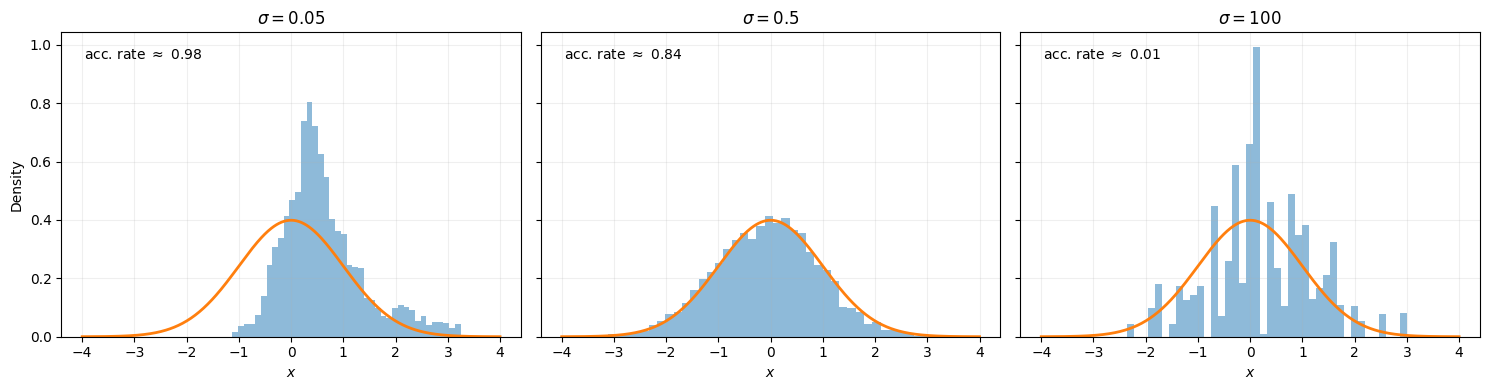

In [49]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# ------------------------------------------------
# 1. 1D Target: Standard Normal N(0,1)
# ------------------------------------------------
def log_target(x):
    """Log-density of N(0,1)."""
    return -0.5 * x**2 - 0.5 * np.log(2 * np.pi)

# ------------------------------------------------
# 2. RW-MH sampler (1D)
# ------------------------------------------------
def rw_mh_1d(log_target, step_size, n_samples, x0=5.0):
    samples = np.zeros(n_samples)
    x_curr = x0
    logp_curr = log_target(x_curr)

    accepted = 0

    for t in range(n_samples):
        #########################################################################################
        #########################################################################################
        proposal = x_curr + np.random.normal(scale=step_size) # IMPORTANT PART ##################
        #########################################################################################
        #########################################################################################

        logp_prop = log_target(proposal)

        # symmetric proposal, so proposal terms cancel
        log_alpha = logp_prop - logp_curr
        if np.log(np.random.rand()) < log_alpha:
            x_curr = proposal
            logp_curr = logp_prop
            accepted += 1

        samples[t] = x_curr

    acc_rate = accepted / n_samples
    return samples, acc_rate

# ------------------------------------------------
# 3. Run three chains with different step sizes
# ------------------------------------------------
step_sizes = [0.05, 0.5, 100]
n_samples = 10000
burn_in = 2000

results = []
for sigma in step_sizes:
    samples, acc_rate = rw_mh_1d(log_target, step_size=sigma, n_samples=n_samples)
    results.append((sigma, samples[burn_in:], acc_rate))

# ------------------------------------------------
# 4. Plot histograms vs target density
# ------------------------------------------------
x_grid = np.linspace(-4, 4, 500)
target_pdf = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x_grid**2)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axes = axes.ravel()

for ax, (sigma, samples_burned, acc_rate) in zip(axes, results):
    # Histogram of samples
    ax.hist(
        samples_burned,
        bins=40,
        density=True,
        alpha=0.5,
        edgecolor='none'
    )

    # Target density
    ax.plot(x_grid, target_pdf, lw=2)

    ax.set_title(rf"$\sigma={sigma}$")
    ax.set_xlabel("$x$")
    ax.grid(alpha=0.2)

    # Put acceptance rate text inside the plot
    ax.text(
        0.05, 0.95,
        rf"acc. rate $\approx$ {acc_rate:.2f}",
        transform=ax.transAxes,
        va="top",
        ha="left"
    )

axes[0].set_ylabel("Density")

plt.tight_layout()
plt.show()


### Notes (1D Random-Walk Metropolis — step-size dependence)

What this section demonstrates
- One-dimensional Random-Walk Metropolis chains are run at different proposal scales to show how step-size affects mixing and acceptance.

What to point out
- Small step sizes produce high acceptance but slow exploration (high autocorrelation). Large step sizes can produce very low acceptance and cause the chain to get stuck. An intermediate step size often gives the best practical trade-off.
- The cell includes histograms and acceptance rate annotations; use those visuals to show how empirical density recovers the target for well-chosen step sizes and fails for bad choices.

## GIBBS SAMPLING

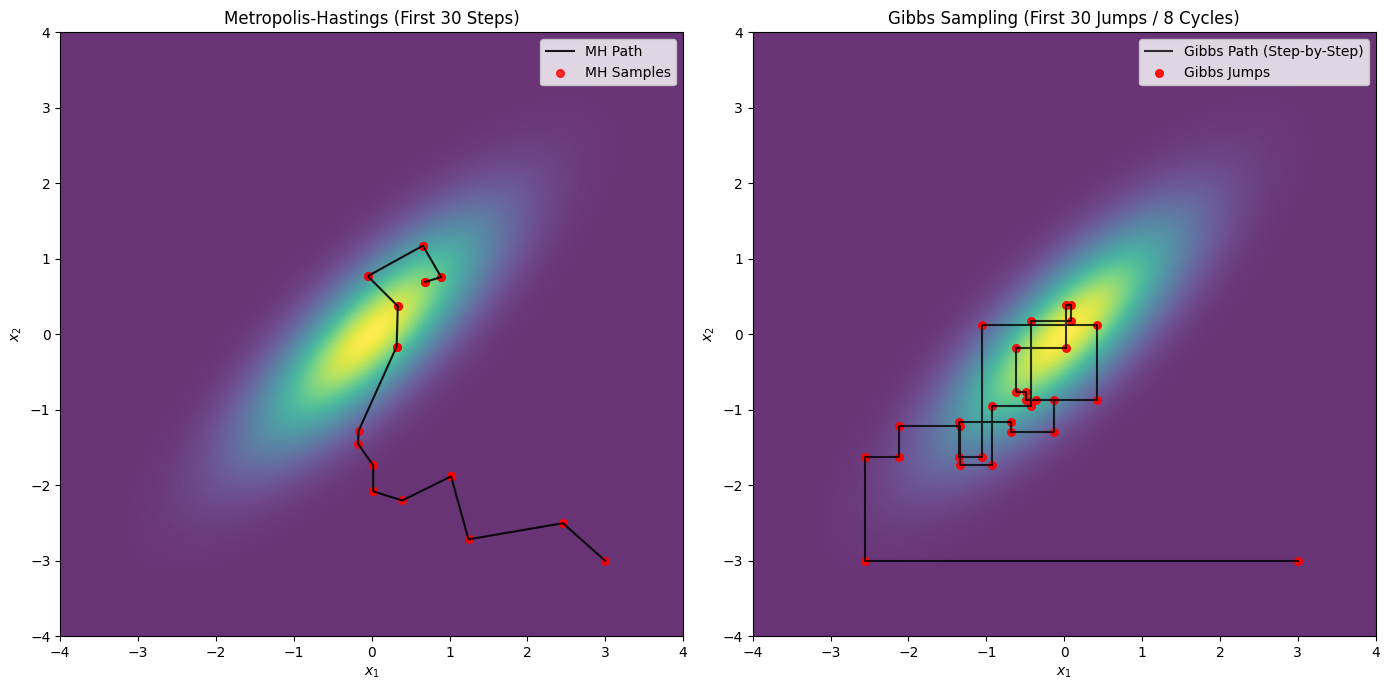

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Target 2D Gaussian
# -----------------------------
np.random.seed(123)

mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, 0.8],
                  [0.8, 1.0]])

Sigma_inv = np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)
norm_const = 1.0 / (2.0 * np.pi * np.sqrt(Sigma_det))

def log_target(x):
    """Log of 2D Gaussian density."""
    dx = x - mu
    return -0.5 * np.dot(dx.T, np.dot(Sigma_inv, dx)) + np.log(norm_const)

# Parameters for conditional distributions (for Gibbs)
sigma1 = np.sqrt(Sigma[0,0])
sigma2 = np.sqrt(Sigma[1,1])
rho = Sigma[0,1] / (sigma1 * sigma2)

cond_var1 = sigma1**2 * (1 - rho**2) # Variance of x1 | x2
cond_var2 = sigma2**2 * (1 - rho**2) # Variance of x2 | x1

# -----------------------------
# 2. Run MCMC (RW-MH)
# -----------------------------
n_samples_mh = 100 
step_size = 0.5

mh_samples = np.zeros((n_samples_mh, 2))
x_curr_mh = np.array([3.0, -3.0])
mh_samples[0] = x_curr_mh
logp_curr_mh = log_target(x_curr_mh)

for t in range(1, n_samples_mh):
    proposal = x_curr_mh + np.random.normal(scale=step_size, size=2)
    logp_prop = log_target(proposal)

    log_alpha = logp_prop - logp_curr_mh
    if np.log(np.random.rand()) < log_alpha:
        x_curr_mh = proposal
        logp_curr_mh = logp_prop

    mh_samples[t] = x_curr_mh

# -----------------------------
# 2. Run Gibbs Sampling (Storing every jump)
# -----------------------------
n_gibbs_cycles = 50 
gibbs_jumps = [] # List to store the state after EVERY sub-step

x_curr_gibbs = np.array([3.0, -3.0]) 
gibbs_jumps.append(x_curr_gibbs.copy())

for t in range(n_gibbs_cycles):
    ################################################################################################################
    ################################################################################################################
    ################################################################################################################
    # Step 1: Sample x1 | x2_prev (Horizontal jump)
    ################################################################################################################
    ################################################################################################################
    x1_prev, x2_prev = x_curr_gibbs

    # Calculate conditional mean and sample x1
    mean_x1_cond = mu[0] + rho * (sigma1/sigma2) * (x2_prev - mu[1])
    x1_new = np.random.normal(loc=mean_x1_cond, scale=np.sqrt(cond_var1))

    # Store the intermediate state (x1_new, x2_prev)
    x_curr_gibbs = np.array([x1_new, x2_prev])
    gibbs_jumps.append(x_curr_gibbs.copy()) 
    ################################################################################################################
    ################################################################################################################
    # Step 2: Sample x2 | x1_new (Vertical jump)
    # Use the newly sampled x1
    mean_x2_cond = mu[1] + rho * (sigma2/sigma1) * (x1_new - mu[0])
    x2_new = np.random.normal(loc=mean_x2_cond, scale=np.sqrt(cond_var2))
    ################################################################################################################
    ################################################################################################################
    ################################################################################################################

    # Store the final state of the cycle (x1_new, x2_new)
    x_curr_gibbs = np.array([x1_new, x2_new])
    gibbs_jumps.append(x_curr_gibbs.copy()) 

gibbs_jumps_array = np.array(gibbs_jumps)


# -----------------------------
# 3. Background Heatmap of Target PDF
# -----------------------------
xmin, xmax = -4, 4
ymin, ymax = -4, 4

grid_points = 400
x = np.linspace(xmin, xmax, grid_points)
y = np.linspace(ymin, ymax, grid_points)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

dx = pos - mu
exp_term = -0.5 * np.einsum('...i,ij,...j->...', dx, Sigma_inv, dx)
pdf = norm_const * np.exp(exp_term)

# -----------------------------
# 4. Plotting MH and Gibbs in the SAME ROW
# -----------------------------

n_plot_jumps = 30 
n_plot_steps_mh = 30 

# Create one figure with 1 row and 2 columns of subplots
fig, (ax_mh, ax_gibbs) = plt.subplots(1, 2, figsize=(14, 7)) 

# --- Plot 1: Metropolis-Hastings (Left Subplot) ---
ax_mh.imshow(
    pdf, extent=[xmin, xmax, ymin, ymax], origin="lower", aspect="auto", cmap="viridis", alpha=0.8,
)
ax_mh.plot(mh_samples[:n_plot_steps_mh, 0], mh_samples[:n_plot_steps_mh, 1], color="black", lw=1.5, alpha=0.9, label='MH Path')
ax_mh.scatter(mh_samples[:n_plot_steps_mh, 0], mh_samples[:n_plot_steps_mh, 1], s=30, alpha=0.8, color="red", label='MH Samples')
ax_mh.set_xlim(xmin, xmax)
ax_mh.set_ylim(ymin, ymax)
ax_mh.set_title(f"Metropolis-Hastings (First {n_plot_steps_mh} Steps)")
ax_mh.set_xlabel(r"$x_1$")
ax_mh.set_ylabel(r"$x_2$")
ax_mh.legend()


# --- Plot 2: Gibbs Sampling (Right Subplot, showing every sub-step) ---
ax_gibbs.imshow(
    pdf, extent=[xmin, xmax, ymin, ymax], origin="lower", aspect="auto", cmap="viridis", alpha=0.8,
)
ax_gibbs.plot(gibbs_jumps_array[:n_plot_jumps, 0], gibbs_jumps_array[:n_plot_jumps, 1], 
              color="black", lw=1.5, alpha=0.8, label='Gibbs Path (Step-by-Step)')

ax_gibbs.scatter(gibbs_jumps_array[:n_plot_jumps, 0], gibbs_jumps_array[:n_plot_jumps, 1], 
                 s=30, alpha=0.9, color="red", label='Gibbs Jumps') 

ax_gibbs.set_xlim(xmin, xmax)
ax_gibbs.set_ylim(ymin, ymax)
ax_gibbs.set_title(f"Gibbs Sampling (First {n_plot_jumps} Jumps / 8 Cycles)")
ax_gibbs.set_xlabel(r"$x_1$")
ax_gibbs.set_ylabel(r"$x_2$")
ax_gibbs.legend()

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

### Notes (Gibbs sampling vs Metropolis-Hastings)

What this section demonstrates
- The Gibbs sampler uses conditional sampling for each coordinate (horizontal and vertical jumps), while Metropolis–Hastings performs joint proposals. The side-by-side plots let you compare the two behaviours: Gibbs tends to alternate directional moves and can traverse correlated distributions effectively when conditional distributions are convenient.

Talk pointers
- Use this slide to contrast the shape and behavior of Gibbs trajectories vs MH paths — Gibbs often produces more structured coordinate-wise moves while MH has a more isotropic random-walk trajectory depending on the proposal.

## Auxiliary Variable MCMC

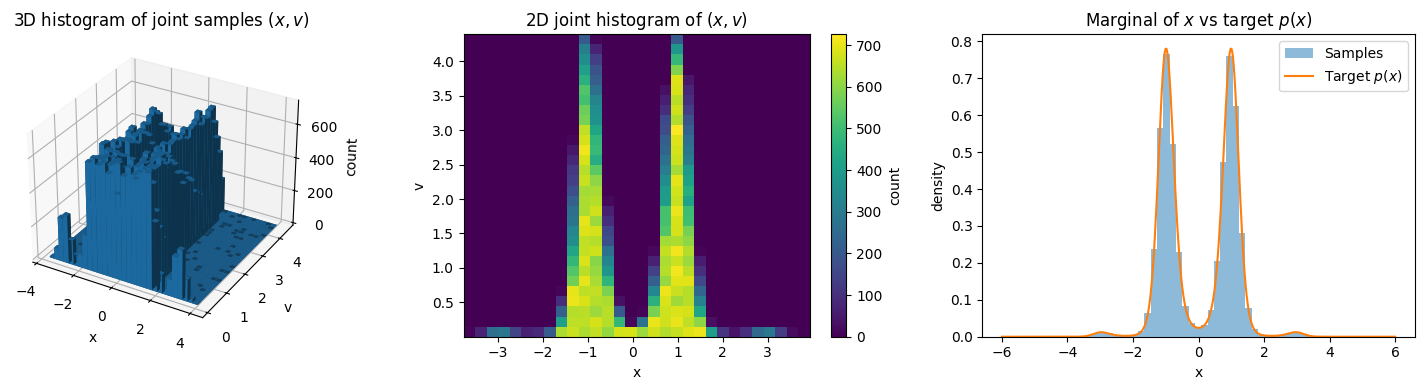

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D

# -------------------------
# Target log-density (unnormalized)
# -------------------------
def log_pdf(x):
    # Multimodal example
    return -0.5 * x**2 - 2.0 * np.cos(3.0 * x)

# -------------------------
# Simple 1D slice sampler (with stepping-out)
# -------------------------
def slice_sample_1d(logpdf, x0, w=1.0, n_samples=5000, m=100):
    """
    Univariate slice sampling with stepping-out.

    Returns
    -------
    x_samples : (n_samples,)
        Samples from the target p(x).
    v_samples : (n_samples,)
        Slice heights v ~ Uniform(0, exp(logpdf(x))) giving joint (x, v) samples.
    """
    x_samples = np.zeros(n_samples)
    v_samples = np.zeros(n_samples)
    x = x0

    for i in range(n_samples):
        # Current log f(x)
        log_fx = logpdf(x)

        # Sample vertical level y ~ Uniform(0, f(x))
        u = np.random.uniform()
        log_y = log_fx + np.log(u)

        # Initial interval [L, R]
        L = x - np.random.uniform(0, w)
        R = L + w

        # Stepping-out up to m steps
        J = int(np.floor(m * np.random.uniform()))
        K = (m - 1) - J

        while J > 0 and logpdf(L) > log_y:
            L -= w
            J -= 1
        while K > 0 and logpdf(R) > log_y:
            R += w
            K -= 1

        # Shrink sampling inside [L, R]
        while True:
            x_prop = np.random.uniform(L, R)
            if logpdf(x_prop) >= log_y:
                x = x_prop
                break
            else:
                if x_prop < x:
                    L = x_prop
                else:
                    R = x_prop

        # Store x
        x_samples[i] = x

        # Sample v | x ~ Uniform(0, f(x)) -> joint (x, v)
        fx = np.exp(logpdf(x))
        v_samples[i] = np.random.uniform(0.0, fx)

    return x_samples, v_samples

# -------------------------
# Run the sampler
# -------------------------
np.random.seed(123)

x0 = 0.0
n_samples = 100000
burn_in = 1000

x_samples, v_samples = slice_sample_1d(log_pdf, x0, w=1.5, n_samples=n_samples, m=50)

# Discard burn-in
x_post = x_samples[burn_in:]
v_post = v_samples[burn_in:]

# -------------------------
# Target density p(x) for comparison
# -------------------------
xs = np.linspace(-6, 6, 400)
tilde_p = np.exp(log_pdf(xs))
Zp = np.trapz(tilde_p, xs)
p_x = tilde_p / Zp

# -------------------------
# Figure with 3 subplots
#   1) 3D histogram of (x, v)
#   2) 2D joint (x, v) heatmap with viridis
#   3) Marginal x histogram + p(x)
# -------------------------
fig = plt.figure(figsize=(15, 4))

# (1) 3D histogram of (x, v)
ax1 = fig.add_subplot(131, projection='3d')

n_bins_x = 30
n_bins_v = 30

H, xedges, vedges = np.histogram2d(x_post, v_post, bins=[n_bins_x, n_bins_v])

# Bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
v_centers = 0.5 * (vedges[:-1] + vedges[1:])

Xc, Vc = np.meshgrid(x_centers, v_centers, indexing='ij')
Xc = Xc.ravel()
Vc = Vc.ravel()
Zc = np.zeros_like(Xc)

dx = (xedges[1] - xedges[0]) * np.ones_like(Xc)
dv = (vedges[1] - vedges[0]) * np.ones_like(Vc)
dz = H.ravel()

ax1.bar3d(Xc, Vc, Zc, dx, dv, dz)
ax1.set_title("3D histogram of joint samples $(x, v)$")
ax1.set_xlabel("x")
ax1.set_ylabel("v")
ax1.set_zlabel("count")

# (2) 2D joint (x, v) histogram with viridis
ax2 = fig.add_subplot(132)

Xedges, Vedges = np.meshgrid(xedges, vedges, indexing='ij')
im = ax2.pcolormesh(Xedges, Vedges, H, cmap='viridis', shading='auto')
ax2.set_title("2D joint histogram of $(x, v)$")
ax2.set_xlabel("x")
ax2.set_ylabel("v")
fig.colorbar(im, ax=ax2, label="count")

# (3) Marginal x histogram + target p(x)
ax3 = fig.add_subplot(133)
ax3.hist(x_post, bins=40, density=True, alpha=0.5, label="Samples")
ax3.plot(xs, p_x, label="Target $p(x)$")
ax3.set_title("Marginal of $x$ vs target $p(x)$")
ax3.set_xlabel("x")
ax3.set_ylabel("density")
ax3.legend()

plt.tight_layout()
plt.show()


### Notes (slice sampling / auxiliary-variable MCMC)

What this section demonstrates
- A univariate slice sampler (with stepping-out) that generates (x, v) pairs — where v is a slice height — and visualizes the joint and marginal distributions. This is useful for showing auxiliary-variable samplers and how they adapt exploration to local shape of the density.

Key takeaways
- The 3D and 2D joint histograms show how slice sampling explores complex and multimodal targets effectively.
- The marginal comparison confirms the slice samples approximate the target density well (after burn-in).

## HMC

In [ ]:
import sys
!{sys.executable} -m pip install "jax[cpu]" numpyro arviz


In [53]:
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import matplotlib.pyplot as plt


sample: 100%|██████████| 3000/3000 [00:01<00:00, 2533.64it/s, 7 steps of size 4.73e-01. acc. prob=0.89]


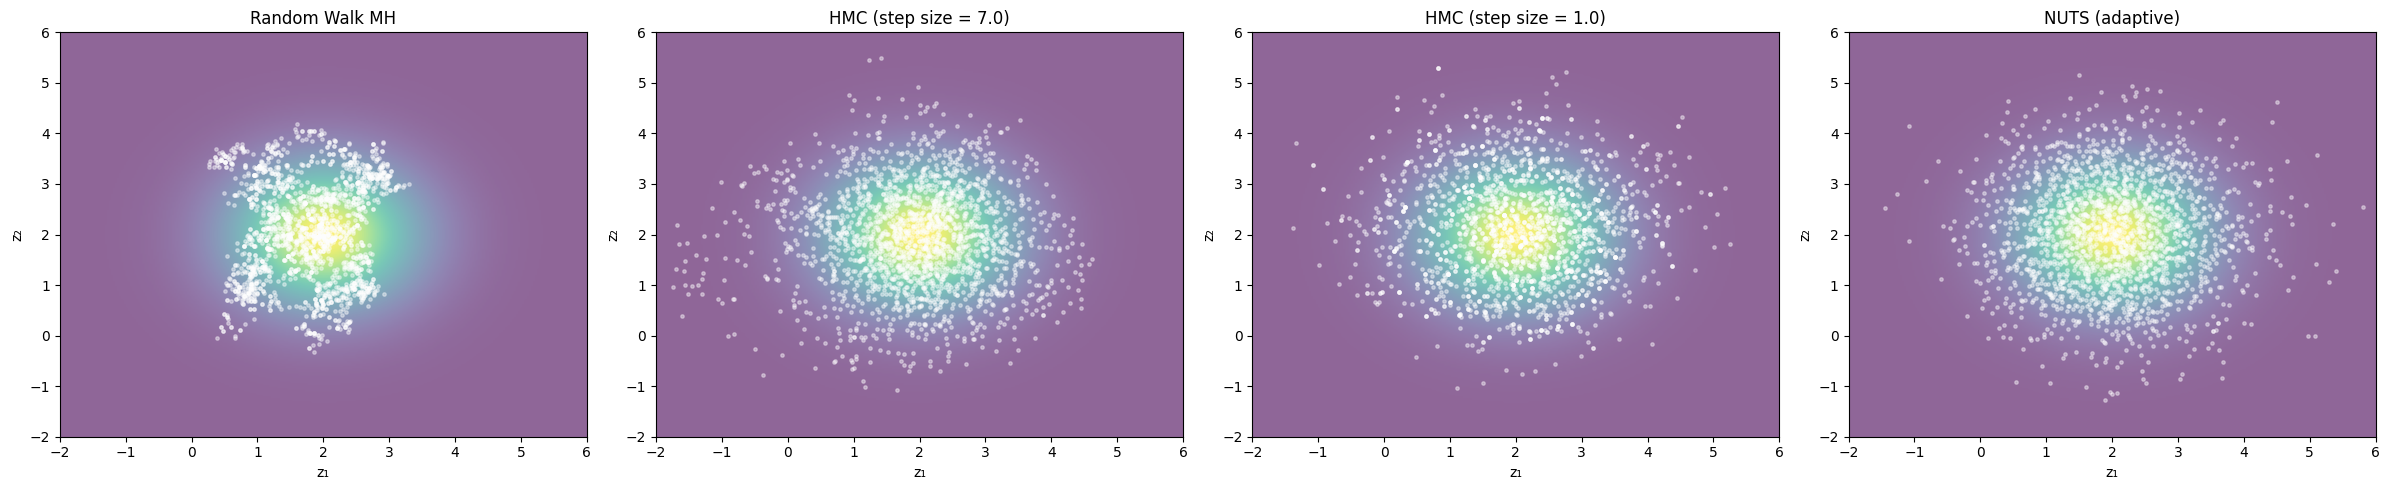

In [ ]:
import time
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

from numpyro.infer.initialization import init_to_uniform
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC


# ============================================================
# High-dimensional single Gaussian (50D)
# ============================================================

D = 50
NUM_SAMPLES = 2000
NUM_WARMUP = 1000

key = random.PRNGKey(0)

# Target: a single Gaussian N(mean, I)
mean = jnp.ones(D) * 2.0
cov = jnp.eye(D)


def log_prob_gauss(z):
    """Log-density of the 50D Gaussian target."""
    return dist.MultivariateNormal(mean, cov).log_prob(z)


# ============================================================
# NumPyro model: target is exactly the Gaussian
# ============================================================

def model_gauss():
    # Directly sample from the target Gaussian; this is the posterior.
    numpyro.sample("z", dist.MultivariateNormal(mean, cov))


# ============================================================
# 1) Metropolis–Hastings (manual)
# ============================================================

def metropolis_hastings(rng_key, log_prob, dim, n_samples, step_size=0.05):
    samples = []
    key = rng_key

    # initial state
    key, subkey = random.split(key)
    z = random.normal(subkey, shape=(dim,))
    current_lp = log_prob(z)

    for _ in range(n_samples):
        key, subkey = random.split(key)
        proposal = z + step_size * random.normal(subkey, shape=(dim,))
        proposal_lp = log_prob(proposal)

        acc_prob = jnp.exp(proposal_lp - current_lp)
        key, subkey = random.split(key)
        if random.uniform(subkey) < acc_prob:
            z = proposal
            current_lp = proposal_lp

        samples.append(z)

    return jnp.stack(samples)


t0 = time.time()
mh_raw = metropolis_hastings(key, log_prob_gauss, D, NUM_SAMPLES + NUM_WARMUP, step_size=0.1)
mh_samples = mh_raw[NUM_WARMUP:]
t_mh = time.time() - t0


# ============================================================
# 2) HMC (dos step sizes distintos)
# ============================================================

# HMC con step size "grande" (debería mezclar razonablemente bien)
hmc_kernel_big = HMC(model_gauss, step_size=0.001, adapt_step_size=False)
mcmc_hmc_big = MCMC(hmc_kernel_big, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)

t0 = time.time()
mcmc_hmc_big.run(key)
t_hmc_big = time.time() - t0
hmc_samples_big = mcmc_hmc_big.get_samples()["z"]

# HMC con step size pequeño (explora muy lento)
hmc_kernel_small = HMC(model_gauss, step_size=1.0, adapt_step_size=False)
mcmc_hmc_small = MCMC(hmc_kernel_small, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)

t0 = time.time()
mcmc_hmc_small.run(key)
t_hmc_small = time.time() - t0
hmc_samples_small = mcmc_hmc_small.get_samples()["z"]


# ============================================================
# 3) NUTS (adaptive, large initial step size)
# ============================================================

nuts_kernel = NUTS(
    model_gauss,
    init_strategy=init_to_uniform(),
    step_size=1.0,          # starting step size (will be adapted)
    adapt_step_size=True
)
mcmc_nuts = MCMC(nuts_kernel, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)

t0 = time.time()
mcmc_nuts.run(key)
t_nuts = time.time() - t0
nuts_samples = mcmc_nuts.get_samples()["z"]


# ============================================================
# Plot: true 2D Gaussian + samples (first 2 dims)
# ============================================================

def plot_ground_truth(ax):
    """Draw the true 2D marginal of the 50D Gaussian in viridis."""
    x = jnp.linspace(-2, 6, 250)
    y = jnp.linspace(-2, 6, 250)
    X, Y = jnp.meshgrid(x, y)

    # grid shape: (250, 250, 2)
    grid = jnp.stack([X, Y], axis=-1)

    # 2D marginal: mean[:2], cov[:2, :2]
    mvn2d = dist.MultivariateNormal(mean[:2], cov[:2, :2])
    logp = mvn2d.log_prob(grid)
    density = jnp.exp(logp)

    ax.imshow(
        density,
        extent=[x.min(), x.max(), y.min(), y.max()],
        origin="lower",
        cmap="viridis",
        alpha=0.6,
        aspect="auto"
    )


plt.figure(figsize=(24, 5))

# 1) MH
ax = plt.subplot(1, 4, 1)
plot_ground_truth(ax)
ax.scatter(mh_samples[:, 0], mh_samples[:, 1], s=6, alpha=0.4, color="white")
ax.set_title("Random Walk MH")
ax.set_xlabel("z₁")
ax.set_ylabel("z₂")

# 2) HMC step size grande
ax = plt.subplot(1, 4, 2)
plot_ground_truth(ax)
ax.scatter(hmc_samples_big[:, 0], hmc_samples_big[:, 1], s=6, alpha=0.4, color="white")
ax.set_title("HMC (step size = 0.001)")
ax.set_xlabel("z₁")
ax.set_ylabel("z₂")

# 3) HMC step size pequeño
ax = plt.subplot(1, 4, 3)
plot_ground_truth(ax)
ax.scatter(hmc_samples_small[:, 0], hmc_samples_small[:, 1], s=6, alpha=0.4, color="white")
ax.set_title("HMC (step size = 1.0)")
ax.set_xlabel("z₁")
ax.set_ylabel("z₂")

# 4) NUTS
ax = plt.subplot(1, 4, 4)
plot_ground_truth(ax)
ax.scatter(nuts_samples[:, 0], nuts_samples[:, 1], s=6, alpha=0.4, color="white")
ax.set_title("NUTS (adaptive)")
ax.set_xlabel("z₁") 
ax.set_ylabel("z₂")

plt.tight_layout()
plt.show()

### Notes (HMC / NUTS experiments)

What this section demonstrates
- This block compares a manually coded Metropolis–Hastings implementation against HMC (two different step-size settings) and NUTS (adaptive). The target is a high-dimensional Gaussian where HMC-based algorithms are expected to mix much better than a simple RW-MH.

What to highlight in the talk
- HMC with a reasonable step size explores high-dimensional targets effectively and produces low-autocorrelation samples; if the step size is too small or too large the behavior degrades.
- NUTS automatically adapts and often gives robust behaviour across problems; use the plots (2D marginals for first two dimensions) to show differences in sample quality visually.

## CONVERGENCE

In [ ]:
import sys
!{sys.executable} -m pip install arviz

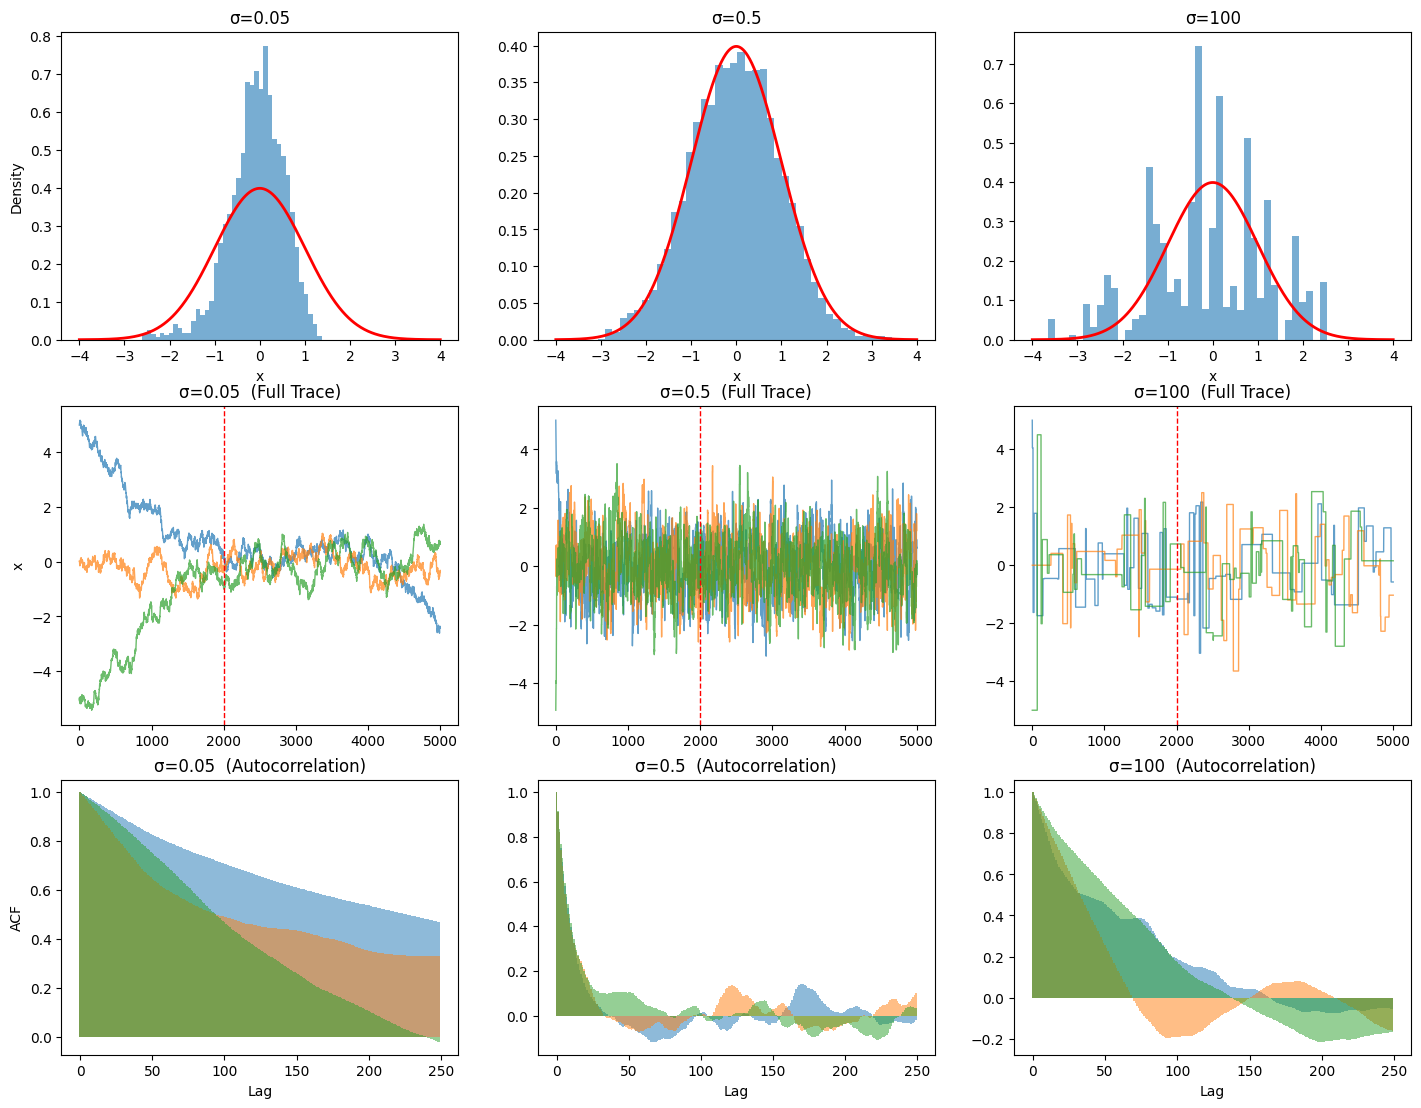

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# -------------------------------------------
# GLOBAL RANDOM SEED (as requested)
# -------------------------------------------
np.random.seed(12345)

# -------------------------------------------
# 1. Target: Normal(0,1)
# -------------------------------------------
def log_target(x):
    return -0.5 * x**2 - 0.5 * np.log(2 * np.pi)

# -------------------------------------------
# 2. Random Walk Metropolis–Hastings (1D)
# -------------------------------------------
def rw_mh_1d(log_target, step_size, n_samples, x0):
    samples = np.zeros(n_samples)
    x_curr = x0
    logp_curr = log_target(x_curr)
    accepted = 0

    for t in range(n_samples):
        proposal = x_curr + np.random.normal(scale=step_size)
        logp_prop = log_target(proposal)

        log_alpha = logp_prop - logp_curr
        if np.log(np.random.rand()) < log_alpha:
            x_curr = proposal
            logp_curr = logp_prop
            accepted += 1

        samples[t] = x_curr

    return samples, accepted / n_samples

# -------------------------------------------
# 3. Run multiple chains + diagnostics
# -------------------------------------------
def run_chains_and_analyze(log_target, step_sizes, n_samples, n_chains, burn_in):

    diagnostics = {}
    all_chains_data = {}

    x0_starts = np.linspace(5.0, -5.0, n_chains)

    for sigma in step_sizes:

        chains = []
        acc_rates = []

        for i in range(n_chains):
            samples, acc_rate = rw_mh_1d(
                log_target,
                step_size=sigma,
                n_samples=n_samples,
                x0=x0_starts[i]
            )
            chains.append(samples)
            acc_rates.append(acc_rate)

        chains_array = np.array(chains)
        all_chains_data[sigma] = chains_array

        # burn-in for diagnostics
        burned = chains_array[:, burn_in:]

        # ArviZ
        idata = az.from_dict(posterior={"x": burned})

        r_hat = az.rhat(idata)["x"].item()
        ess_bulk = az.ess(idata, method="bulk")["x"].item()

        diagnostics[sigma] = {
            "r_hat": r_hat,
            "ess_bulk": ess_bulk,
            "avg_acc_rate": np.mean(acc_rates)
        }

    return all_chains_data, diagnostics

# -------------------------------------------
# 4. Execute
# -------------------------------------------
n_samples = 5000
n_chains = 3
burn_in = 2000
step_sizes = [0.05, 0.5, 100]

all_chains_data, diagnostics = run_chains_and_analyze(
    log_target,
    step_sizes,
    n_samples,
    n_chains,
    burn_in
)

from IPython.display import display, HTML

# --- CONVERGENCE DIAGNOSTICS TABLE (centered) ---
header = ["σ", "R̂", "ESS", "AccRate"]
row_format = "| {:>7} | {:>7} | {:>7} | {:>7} |"
title_format = "| {:>7} | {:>8} | {:>7} | {:>7} |"


lines = []
lines.append("+---------+---------+---------+---------+")
lines.append(title_format.format(*header))
lines.append("+---------+---------+---------+---------+")

for sigma in step_sizes:
    d = diagnostics[sigma]
    lines.append(row_format.format(
        f"{sigma:.3g}",
        f"{d['r_hat']:.3f}",
        f"{d['ess_bulk']:.0f}",
        f"{d['avg_acc_rate']:.3f}",
    ))

lines.append("+---------+---------+---------+---------+")

table_str = "\n".join(lines)

html = f"""
<div style="display:flex; justify-content:center; margin-top:10px; margin-bottom:10px;">
  <pre style="font-family: monospace; font-size: 13px;">
{table_str}
  </pre>
</div>
"""

display(HTML(html))

# -------------------------------------------
# 5. Visualization (clean version)
# -------------------------------------------
fig = plt.figure(figsize=(15, 11))

# Row 1: histogram  (ANTES era full trace)
gs_hist = fig.add_gridspec(1, 3, left=0.05, right=0.95,
                           top=0.98, bottom=0.70, hspace=0.15)

# Row 2: full trace (ANTES era histogram)
gs_trace = fig.add_gridspec(1, 3, left=0.05, right=0.95,
                            top=0.64, bottom=0.35, hspace=0.20)

# Row 3: autocorrelation bars (igual que antes)
gs_acf = fig.add_gridspec(1, 3, left=0.05, right=0.95,
                          top=0.30, bottom=0.05, hspace=0.20)

ax_hist = [fig.add_subplot(gs_hist[0, i]) for i in range(3)]
ax_trace = [fig.add_subplot(gs_trace[0, i]) for i in range(3)]
ax_acf = [fig.add_subplot(gs_acf[0, i]) for i in range(3)]

# target pdf
x_grid = np.linspace(-4, 4, 500)
target_pdf = np.exp(-0.5*x_grid**2) / np.sqrt(2*np.pi)

for i, sigma in enumerate(step_sizes):
    full = all_chains_data[sigma]
    burned = full[:, burn_in:]

    # ---- HISTOGRAM (AHORA ARRIBA, FILA 1) ----
    ax_hist[i].hist(burned.flatten(), bins=40, density=True, alpha=0.6)
    ax_hist[i].plot(x_grid, target_pdf, "r", lw=2)
    ax_hist[i].set_title(f"σ={sigma}")
    ax_hist[i].set_xlabel("x")
    if i == 0:
        ax_hist[i].set_ylabel("Density")

    # ---- FULL TRACE (AHORA FILA 2) ----
    for ch in range(n_chains):
        ax_trace[i].plot(full[ch], lw=1, alpha=0.7)
    ax_trace[i].axvline(burn_in, color="red", ls="--", lw=1)
    ax_trace[i].set_title(f"σ={sigma}  (Full Trace)")
    if i == 0:
        ax_trace[i].set_ylabel("x")

    # ---- AUTOCORRELATION (BARS, FILA 3) ----
    max_lag = 250
    lags = np.arange(max_lag)

    for ch in range(n_chains):
        acf_vals = az.autocorr(burned[ch])[:max_lag]
        ax_acf[i].bar(lags, acf_vals, alpha=0.5, width=1.0)

    ax_acf[i].set_title(f"σ={sigma}  (Autocorrelation)")
    ax_acf[i].set_xlabel("Lag")
    if i == 0:
        ax_acf[i].set_ylabel("ACF")

plt.tight_layout()
plt.show()


### Notes (Convergence diagnostics and comparisons)

What this section demonstrates
- Multiple chains are run at different proposal scales and diagnostic metrics (R̂, ESS, acceptance rate) are computed with ArviZ to show how step-size affects convergence.

Key observations to mention
- Poorly tuned step size can produce low effective sample sizes and high R̂ values (indicating non-convergence). The histograms, traces, and autocorrelation plots give a clear visual way to discuss mixing and the effects of tuning.
- This section is ideal for a short talk segment on practical diagnostics and how to interpret R̂ and ESS during model checking.


## Reversible Jump MCMC

In [57]:
import numpy as np
from numpy.random import default_rng
from math import log, sqrt, pi

rng = default_rng(42)  # for reproducibility


# ==========================
# 1. Helper functions
# ==========================

def normal_pdf(x, mean, sd):
    """Univariate normal PDF N(mean, sd^2)."""
    return (1.0 / (sd * sqrt(2 * pi))) * np.exp(-0.5 * ((x - mean) / sd) ** 2)


def log_normal_pdf(x, mean, sd):
    """Log of univariate normal PDF."""
    return -0.5 * np.log(2 * pi * sd**2) - 0.5 * ((x - mean) / sd) ** 2


def logsumexp(arr):
    """Stable log-sum-exp for 1D array."""
    m = np.max(arr)
    return m + np.log(np.sum(np.exp(arr - m)))


# ==========================
# 2. Synthetic data from a GMM
# ==========================

def generate_synthetic_gmm_data(n_samples=200):
    """Generate 1D data from a 3-component Gaussian mixture."""
    true_means = np.array([-5.0, 0.0, 4.0])
    true_sd = 0.4
    weights = np.array([0.3, 0.4, 0.3])

    z = rng.choice(len(true_means), size=n_samples, p=weights)
    x = rng.normal(true_means[z], true_sd)
    return x, true_means, true_sd


# ==========================
# 3. Posterior for GMM with K components (means only)
# ==========================

def log_prior_K(K, K_max):
    """
    Prior on number of components K.
    Here: simple uniform on {1,...,K_max}.
    """
    if K < 1 or K > K_max:
        return -np.inf
    # Uniform over allowed K => constant, can return 0.0
    return 0.0


def log_prior_mu(mu, tau_prior=5.0):
    """
    Prior on the means: independent N(0, tau_prior^2).
    mu: array of shape (K,)
    """
    return np.sum(log_normal_pdf(mu, 0.0, tau_prior))


def log_likelihood(x, mu, sigma):
    """
    Log-likelihood under a GMM with equal weights and fixed variance.
    x: (N,)
    mu: (K,)
    sigma: scalar
    p(x_n | mu) = (1/K) sum_k N(x_n | mu_k, sigma^2)
    """
    K = len(mu)
    if K == 0:
        return -np.inf
    ll = 0.0
    for xn in x:
        # log( 1/K * sum_k N(xn | mu_k) ) = logsumexp(log N - log K)
        log_comp = np.array([log_normal_pdf(xn, mk, sigma) for mk in mu])
        ll += logsumexp(log_comp - log(K))
    return ll


def log_posterior(x, mu, sigma, K_max, tau_prior=5.0):
    """
    Unnormalized log posterior log p(K, mu | x)
    where K = len(mu).
    """
    K = len(mu)
    lpK = log_prior_K(K, K_max)
    if not np.isfinite(lpK):
        return -np.inf
    lp_mu = log_prior_mu(mu, tau_prior=tau_prior)
    ll = log_likelihood(x, mu, sigma)
    return lpK + lp_mu + ll


# ==========================
# 4. RJMCMC moves: local, split, merge
# ==========================

def propose_local_move(mu, rw_sd=0.2):
    """
    Local random-walk MH move:
    pick one component index at random and perturb its mean.
    """
    K = len(mu)
    idx = rng.integers(K)  # which component to move
    mu_prop = mu.copy()
    mu_prop[idx] = rng.normal(mu[idx], rw_sd)
    return mu_prop, idx


def propose_split(mu, beta=0.5, u_sd=0.5):
    """
    Split move:
    - pick one component c
    - draw auxiliary variable u ~ N(0, u_sd^2)
    - create two new means: mu_c1 = mu_c - u * beta, mu_c2 = mu_c + u * beta
    Returns: mu_prop, c, u
    """
    K = len(mu)
    c = rng.integers(K)  # which component to split
    mu_c = mu[c]
    u = rng.normal(0.0, u_sd)  # auxiliary variable
    mu_c1 = mu_c - u * beta
    mu_c2 = mu_c + u * beta

    # Build new array of means with K+1 components
    mu_prop = np.empty(K + 1)
    mu_prop[:c] = mu[:c]
    mu_prop[c] = mu_c1
    mu_prop[c + 1] = mu_c2
    mu_prop[c + 2:] = mu[c + 1:]

    return mu_prop, c, u


def propose_merge(mu):
    """
    Merge move (inverse of split):
    - pick one component i uniformly
    - find nearest neighbour j
    - merge them into mu_new = (mu_i + mu_j)/2
    Returns: mu_prop, i, j
    """
    K = len(mu)
    if K < 2:
        return None, None, None  # can't merge

    i = rng.integers(K)  # a component
    # find nearest neighbor j
    dists = np.abs(mu - mu[i])
    dists[i] = np.inf
    j = np.argmin(dists)

    mu_i, mu_j = mu[i], mu[j]
    mu_new = 0.5 * (mu_i + mu_j)

    # construct new means array with K-1 components
    keep_indices = [k for k in range(K) if k not in (i, j)]
    mu_prop = np.empty(K - 1)
    mu_prop[:len(keep_indices)] = mu[keep_indices]
    mu_prop[-1] = mu_new

    return mu_prop, i, j


# ==========================
# 5. RJMCMC driver
# ==========================

def rjmcmc_gmm(
    x,
    n_iters=5000,
    K_init=2,
    K_max=6,
    sigma=0.4,
    tau_prior=5.0,
    rw_sd=0.2,
    split_beta=0.5,
    split_u_sd=0.5,
    p_local=0.6,
    p_split=0.2,
    p_merge=0.2,
):
    """
    RJMCMC sampler for 1D GMM with unknown K.
    - x: data array
    - n_iters: number of MCMC iterations
    - K_init: initial number of components
    - K_max: maximum allowed number of components
    - sigma: known observation noise (component sd)
    - tau_prior: prior sd on component means
    - rw_sd: random-walk sd for local mean updates
    - split_beta, split_u_sd: parameters for split/merge proposals
    - p_local, p_split, p_merge: probabilities of choosing each move type
      (should sum <= 1; remainder is "do nothing" / identity move)
    """
    # Initial state: choose K_init means randomly
    mu_current = rng.normal(0.0, tau_prior, size=K_init)
    logpost_current = log_posterior(x, mu_current, sigma, K_max, tau_prior)

    Ks = []
    mus = []

    for it in range(n_iters):
        K = len(mu_current)

        # Decide which move type to use
        u = rng.random()
        move_type = None
        if u < p_local:
            move_type = "local"
        elif u < p_local + p_split and K < K_max:
            move_type = "split"
        elif u < p_local + p_split + p_merge and K > 1:
            move_type = "merge"
        else:
            move_type = "none"

        if move_type == "local":
            # -----------
            # Local MH update of one mean (dimension stays K)
            # -----------
            mu_prop, idx = propose_local_move(mu_current, rw_sd=rw_sd)
            logpost_prop = log_posterior(x, mu_prop, sigma, K_max, tau_prior)
            log_alpha = logpost_prop - logpost_current  # symmetric RW proposal
            if np.log(rng.random()) < log_alpha:
                mu_current = mu_prop
                logpost_current = logpost_prop

        elif move_type == "split":
            # -----------
            # Split move: K -> K+1
            # -----------
            # Propose new means
            mu_prop, c, u_aux = propose_split(
                mu_current, beta=split_beta, u_sd=split_u_sd
            )
            K_prop = len(mu_prop)

            # Compute log posterior at proposed state
            logpost_prop = log_posterior(x, mu_prop, sigma, K_max, tau_prior)

            # ---- RJMCMC acceptance for split ----
            # Murphy-style factors (ignoring global p_split, p_merge assuming they match):
            # 1) posterior ratio
            #    p(K+1, mu_prop) / p(K, mu_current)
            # 2) proposal ratio for choosing components:
            #   q(K | K+1) / q(K+1 | K)  ≈  (1/(K_prop)) / (1/K)
            # 3) auxiliary variable ratio:
            #   q_{merge}(u_back | K+1, mu_prop) / q_{split}(u_aux | K, mu_current)
            #   = 1 / p(u_aux)
            # 4) Jacobian of split transform: |det J_split| = 2 * beta

            # factor 1: log posterior ratio
            log_alpha = logpost_prop - logpost_current

            # factor 2: combinatorial part (choose which to split vs which pair to merge)
            log_alpha += log(K / K_prop)  # log(K/(K+1))

            # factor 3: auxiliary variable density
            # p(u_aux) under Normal(0, split_u_sd^2)
            log_p_u = log_normal_pdf(u_aux, 0.0, split_u_sd)
            log_alpha += -log_p_u  # = log(1/p(u_aux))

            # factor 4: Jacobian
            log_alpha += log(2.0 * split_beta)

            # MH accept/reject
            if np.log(rng.random()) < log_alpha:
                mu_current = mu_prop
                logpost_current = logpost_prop

        elif move_type == "merge":
            # -----------
            # Merge move: K -> K-1
            # -----------
            mu_prop, i, j = propose_merge(mu_current)
            if mu_prop is None:
                # no-op if cannot merge
                pass
            else:
                K_prop = len(mu_prop)
                logpost_prop = log_posterior(x, mu_prop, sigma, K_max, tau_prior)

                # ---- RJMCMC acceptance for merge ----
                # Inverse of split formula:
                # 1) posterior ratio: p(K-1, mu_prop) / p(K, mu_current)
                # 2) combinatorial: q(K | K-1) / q(K-1 | K) ≈ (1/K_prop) / (1/K)
                # 3) no fresh u sampled here -> aux ratio collapses with Jacobian
                # 4) Jacobian of merge: |det J_merge| = 1/(2 * beta)

                log_alpha = logpost_prop - logpost_current

                # factor 2: combinatorial
                log_alpha += log(K / K_prop)  # log(K/(K-1))

                # factor 4: Jacobian
                log_alpha += log(1.0 / (2.0 * split_beta))

                if np.log(rng.random()) < log_alpha:
                    mu_current = mu_prop
                    logpost_current = logpost_prop

        else:
            # move_type == "none": do nothing this iteration
            pass

        # Store current state
        Ks.append(len(mu_current))
        mus.append(mu_current.copy())

    return np.array(Ks), mus

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data
x, true_means, true_sd = generate_synthetic_gmm_data(n_samples=1000)

# Run RJMCMC
K_trace, mu_trace = rjmcmc_gmm(
    x,
    n_iters=1000,
    K_init=1,
    K_max=6,
    sigma=true_sd,  # pretend we know the true sigma
    tau_prior=5.0,
    rw_sd=0.2,
    split_beta=0.5,
    split_u_sd=0.5,
    p_local=0.5,
    p_split=0.05,
    p_merge=0.45,
)


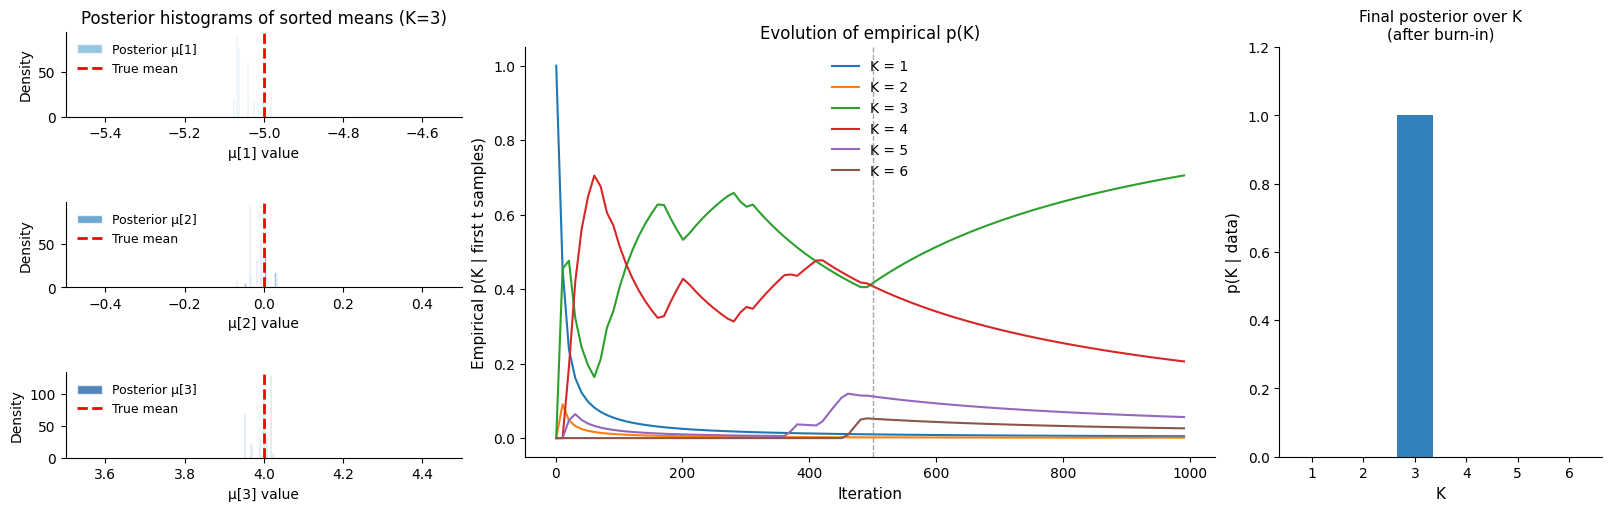

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Settings and helpers
# -------------------------------------------------

T = len(K_trace)
iters = np.arange(1, T + 1)

def normal_pdf(x, mean, sd):
    return (1.0 / (sd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sd) ** 2)

# Burn-in and K values
burn_in = int(0.5 * T)   # simple 50% burn-in
K_vals = np.arange(K_trace.min(), K_trace.max() + 1)
num_K = len(K_vals)

# -------------------------------------------------
# 2. Collect sorted means for iterations with K == len(true_means)
# -------------------------------------------------

K_ref = len(true_means)  # number of true components, e.g. 3

mu_sorted_list = []
for it in range(burn_in, T):
    mu = mu_trace[it]
    if len(mu) == K_ref:
        mu_sorted_list.append(np.sort(mu))  # sort to align components

if len(mu_sorted_list) == 0:
    print(f"Warning: no iterations with K = {K_ref} after burn-in.")
    mu_sorted = None
else:
    mu_sorted = np.vstack(mu_sorted_list)  # shape (n_keep, K_ref)

# -------------------------------------------------
# 3. Evolution of empirical p(K) over iterations
# -------------------------------------------------

freq_evol = np.zeros((num_K, T))  # freq_evol[i, t] = empirical P(K = K_vals[i]) up to t

for i, Kv in enumerate(K_vals):
    indicator = (K_trace == Kv).astype(float)
    cum_counts = np.cumsum(indicator)
    freq_evol[i, :] = cum_counts / iters

# Final posterior over K (post burn-in)
final_freqs = np.array([np.mean(K_trace[burn_in:] == Kv) for Kv in K_vals])

# -------------------------------------------------
# 4. Figure: left = histograms of μ_j; middle = p(K)_t; right = final p(K)
# -------------------------------------------------

plt.style.use("default")

fig = plt.figure(figsize=(16, 5), constrained_layout=True)
outer_gs = fig.add_gridspec(
    1, 3,
    width_ratios=[2.0, 3.0, 1.4]
)

# ---- Left column: stacked histograms for the means (μ1, μ2, μ3, ...) ----
if mu_sorted is not None:
    left_gs = outer_gs[0].subgridspec(K_ref, 1, hspace=0.25)
    ax_mu = []

    # darker blue tones for each component
    blue_colors = ["#6BAED6", "#3182BD", "#08519C"]  # light → dark blues

    for j in range(K_ref):
        axj = fig.add_subplot(left_gs[j, 0])
        ax_mu.append(axj)

        samples_j = mu_sorted[:, j]
        c = blue_colors[j % len(blue_colors)]

        # Histogram of samples for component j
        axj.hist(
            samples_j,
            bins=30,
            density=True,
            alpha=0.7,
            edgecolor="white",
            color=c,
            label=f"Posterior μ[{j+1}]"
        )

        # Vertical line at true mean
        axj.axvline(
            true_means[j],
            color="red",
            linestyle="--",
            linewidth=2,
            label="True mean"
        )

        # >>> FIXED XRANGE: from (mean - 0.5) to (mean + 0.5)
        center = true_means[j]
        axj.set_xlim(center - 0.5, center + 0.5)

        # Own x and y labels for each subplot
        axj.set_xlabel(f"μ[{j+1}] value", fontsize=10)
        axj.set_ylabel("Density", fontsize=10)

        axj.spines["top"].set_visible(False)
        axj.spines["right"].set_visible(False)

        # Individual legend per subplot
        axj.legend(frameon=False, fontsize=9, loc="upper left")

    ax_mu[0].set_title(
        f"Posterior histograms of sorted means (K={K_ref})",
        fontsize=12
    )

else:
    # Fallback: if no iterations with K_ref, leave empty
    ax_dummy = fig.add_subplot(outer_gs[0])
    ax_dummy.text(
        0.5, 0.5,
        f"No samples with K = {K_ref} after burn-in",
        ha="center", va="center"
    )
    ax_dummy.axis("off")

# ---- Middle: evolution of empirical p(K) over iterations ----
ax_mid = fig.add_subplot(outer_gs[1])

plot_thin = 10  # just for plotting
ax_mid_iters = iters[::plot_thin]
for i, Kv in enumerate(K_vals):
    ax_mid.plot(
        ax_mid_iters,
        freq_evol[i, ::plot_thin],
        label=f"K = {Kv}"
    )

ax_mid.axvline(burn_in, color="gray", linestyle="--", linewidth=1, alpha=0.7)

ax_mid.set_xlabel("Iteration", fontsize=11)
ax_mid.set_ylabel("Empirical p(K | first t samples)", fontsize=11)
ax_mid.set_title("Evolution of empirical p(K)", fontsize=12)
ax_mid.legend(frameon=False)
ax_mid.spines["top"].set_visible(False)
ax_mid.spines["right"].set_visible(False)

# ---- Right: final posterior over K ----
ax3 = fig.add_subplot(outer_gs[2])

ax3.bar(K_vals, final_freqs, width=0.7, color="#3182BD")
ax3.set_xlabel("K", fontsize=11)
ax3.set_ylabel("p(K | data)", fontsize=11)
ax3.set_xticks(K_vals)
ax3.set_ylim(0, max(final_freqs) * 1.2 if len(final_freqs) > 0 else 1)
ax3.set_title("Final posterior over K\n(after burn-in)", fontsize=11)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

plt.show()


In [60]:
# Run RJMCMC
K_trace, mu_trace = rjmcmc_gmm(
    x,
    n_iters=10000,
    K_init=1,
    K_max=6,
    sigma=true_sd, 
    tau_prior=5.0,
    rw_sd=0.2,
    split_beta=0.5,
    split_u_sd=0.5,
    p_local=0.5,
    p_split=0.05,
    p_merge=0.45,
)


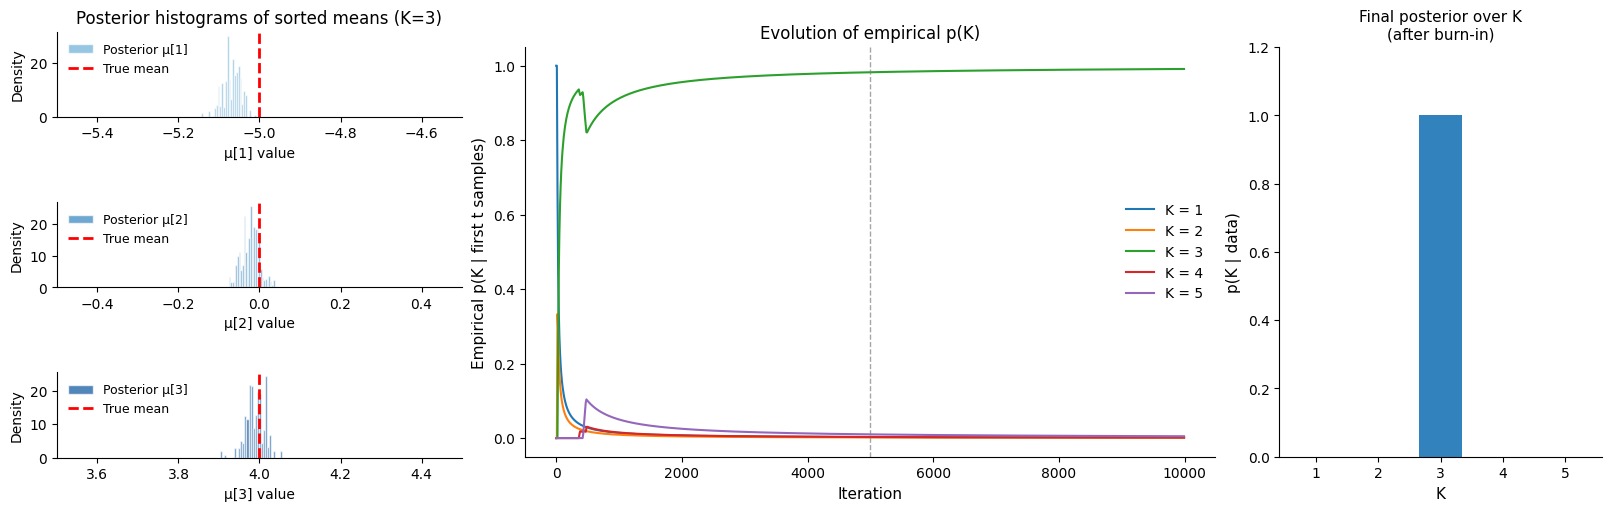

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Settings and helpers
# -------------------------------------------------

T = len(K_trace)
iters = np.arange(1, T + 1)

def normal_pdf(x, mean, sd):
    return (1.0 / (sd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sd) ** 2)

# Burn-in and K values
burn_in = int(0.5 * T)   # simple 50% burn-in
K_vals = np.arange(K_trace.min(), K_trace.max() + 1)
num_K = len(K_vals)

# -------------------------------------------------
# 2. Collect sorted means for iterations with K == len(true_means)
# -------------------------------------------------

K_ref = len(true_means)  # number of true components, e.g. 3

mu_sorted_list = []
for it in range(burn_in, T):
    mu = mu_trace[it]
    if len(mu) == K_ref:
        mu_sorted_list.append(np.sort(mu))  # sort to align components

if len(mu_sorted_list) == 0:
    print(f"Warning: no iterations with K = {K_ref} after burn-in.")
    mu_sorted = None
else:
    mu_sorted = np.vstack(mu_sorted_list)  # shape (n_keep, K_ref)

# -------------------------------------------------
# 3. Evolution of empirical p(K) over iterations
# -------------------------------------------------

freq_evol = np.zeros((num_K, T))  # freq_evol[i, t] = empirical P(K = K_vals[i]) up to t

for i, Kv in enumerate(K_vals):
    indicator = (K_trace == Kv).astype(float)
    cum_counts = np.cumsum(indicator)
    freq_evol[i, :] = cum_counts / iters

# Final posterior over K (post burn-in)
final_freqs = np.array([np.mean(K_trace[burn_in:] == Kv) for Kv in K_vals])

# -------------------------------------------------
# 4. Figure: left = histograms of μ_j; middle = p(K)_t; right = final p(K)
# -------------------------------------------------

plt.style.use("default")

fig = plt.figure(figsize=(16, 5), constrained_layout=True)
outer_gs = fig.add_gridspec(
    1, 3,
    width_ratios=[2.0, 3.0, 1.4]
)

# ---- Left column: stacked histograms for the means (μ1, μ2, μ3, ...) ----
if mu_sorted is not None:
    left_gs = outer_gs[0].subgridspec(K_ref, 1, hspace=0.25)
    ax_mu = []

    # darker blue tones for each component
    blue_colors = ["#6BAED6", "#3182BD", "#08519C"]  # light → dark blues

    for j in range(K_ref):
        axj = fig.add_subplot(left_gs[j, 0])
        ax_mu.append(axj)

        samples_j = mu_sorted[:, j]
        c = blue_colors[j % len(blue_colors)]

        # Histogram of samples for component j
        axj.hist(
            samples_j,
            bins=30,
            density=True,
            alpha=0.7,
            edgecolor="white",
            color=c,
            label=f"Posterior μ[{j+1}]"
        )

        # Vertical line at true mean
        axj.axvline(
            true_means[j],
            color="red",
            linestyle="--",
            linewidth=2,
            label="True mean"
        )

        # >>> FIXED XRANGE: from (mean - 0.5) to (mean + 0.5)
        center = true_means[j]
        axj.set_xlim(center - 0.5, center + 0.5)

        # Own x and y labels for each subplot
        axj.set_xlabel(f"μ[{j+1}] value", fontsize=10)
        axj.set_ylabel("Density", fontsize=10)

        axj.spines["top"].set_visible(False)
        axj.spines["right"].set_visible(False)

        # Individual legend per subplot
        axj.legend(frameon=False, fontsize=9, loc="upper left")

    ax_mu[0].set_title(
        f"Posterior histograms of sorted means (K={K_ref})",
        fontsize=12
    )

else:
    # Fallback: if no iterations with K_ref, leave empty
    ax_dummy = fig.add_subplot(outer_gs[0])
    ax_dummy.text(
        0.5, 0.5,
        f"No samples with K = {K_ref} after burn-in",
        ha="center", va="center"
    )
    ax_dummy.axis("off")

# ---- Middle: evolution of empirical p(K) over iterations ----
ax_mid = fig.add_subplot(outer_gs[1])

plot_thin = 10  # just for plotting
ax_mid_iters = iters[::plot_thin]
for i, Kv in enumerate(K_vals):
    ax_mid.plot(
        ax_mid_iters,
        freq_evol[i, ::plot_thin],
        label=f"K = {Kv}"
    )

ax_mid.axvline(burn_in, color="gray", linestyle="--", linewidth=1, alpha=0.7)

ax_mid.set_xlabel("Iteration", fontsize=11)
ax_mid.set_ylabel("Empirical p(K | first t samples)", fontsize=11)
ax_mid.set_title("Evolution of empirical p(K)", fontsize=12)
ax_mid.legend(frameon=False)
ax_mid.spines["top"].set_visible(False)
ax_mid.spines["right"].set_visible(False)

# ---- Right: final posterior over K ----
ax3 = fig.add_subplot(outer_gs[2])

ax3.bar(K_vals, final_freqs, width=0.7, color="#3182BD")
ax3.set_xlabel("K", fontsize=11)
ax3.set_ylabel("p(K | data)", fontsize=11)
ax3.set_xticks(K_vals)
ax3.set_ylim(0, max(final_freqs) * 1.2 if len(final_freqs) > 0 else 1)
ax3.set_title("Final posterior over K\n(after burn-in)", fontsize=11)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

plt.show()


### Notes (Reversible Jump MCMC — GMM with unknown K)

What this section demonstrates
- A full RJMCMC sampler for a 1D Gaussian mixture where the number of components K is unknown. The sampler implements three moves: local (perturb a mean), split, and merge — producing a Markov chain that explores both parameter values and model dimension.

Observed/expected results
- The posterior over K is computed empirically and plotted (final posterior over K after burn-in). When the sampler mixes well and proposals are balanced, the RJMCMC posterior over K should concentrate near the true number of components used to generate data.
- The left-hand column in the figure (posterior histograms for sorted means) lets you inspect whether the sampler recovers component means for the chosen K.

Talk notes
- Use this section to explain Bayesian model selection with RJMCMC visually — the empirical P(K|data) plot is an effective summary for audiences new to trans-dimensional sampling.

## Final summary and presentation notes

Short summary of what you can say in a talk:
- Start by contrasting MCMC and VI briefly (bias vs asymptotic correctness, speed vs fidelity).
- Show Example 1 to illustrate where VI is fast and accurate (Gaussian posteriors) and present the numeric results (fast VI projection, small relative error, KL measurement shown in the cell outputs).
- Show Example 2 to highlight failure modes for simple VI (single-Gaussian VI collapses on one mode; MCMC recovers both modes in multimodal settings).
- Use the MCMC demos (RW-MH, Gibbs, slice sampling, HMC/NUTS, convergence diagnostics) to explain tuning, mixing, convergence checks, and more advanced samplers. Use visualizations in the notebook as talking points.
- Use the RJMCMC section to explain trans-dimensional inference and to demonstrate empirical posterior over model size K.

Suggested speaking flow (2–3 slides + live demos):
1. Conceptual slide: differences and when to choose VI vs MCMC.
2. Short demo/slide: Example 1 (VI fast — show timings and KL).  
3. Short demo/slide: Example 2 (VI fails, MCMC succeeds — show histogram and best-q collapse).  
4. Quick “toolbox” overview: show the set of MCMC demos (what each one highlights), and finish with convergence diagnostics and RJMCMC as advanced topics.

If you'd like, I can now:
- Prepare a polished slide deck (reveal.js / nbconvert) using these notebook cells, or
- Convert the toy VI projection into a proper ADVI run (PyMC or NumPyro) and show wall-clock comparisons vs NUTS/HMC, or
- Add a short text section with speaker notes for each slide.  

Tell me which of the follow-ups you'd like and I’ll prepare it next.